In [8]:
import torch
from torch import nn, Tensor

import matplotlib.pyplot as plt
#  from sklearn.datasets import make_moons

In [5]:
import numpy as np

def generate_square_points(n_points=256, side_length=2.0):
    points_per_side = n_points // 4
    half = side_length / 2

    # Lati: sinistra → sopra → destra → sotto
    left = torch.stack([
        torch.full((points_per_side,), -half),
        torch.linspace(-half, half, points_per_side)
    ], dim=1)

    top = torch.stack([
        torch.linspace(-half, half, points_per_side),
        torch.full((points_per_side,), half)
    ], dim=1)

    right = torch.stack([
        torch.full((points_per_side,), half),
        torch.linspace(half, -half, points_per_side)
    ], dim=1)

    bottom = torch.stack([
        torch.linspace(half, -half, points_per_side),
        torch.full((points_per_side,), -half)
    ], dim=1)

    square = torch.cat([left, top, right, bottom], dim=0)
    return square


import numpy as np
import torch

def generate_circle_points(n_samples=256):
    points = []

    # Ellisse (testa)
    t = np.linspace(0, 2*np.pi, 1000)

    # Cerchio destro
    x3 = 1.4 * np.cos(t) + 1.5
    y3 = 1.4 * np.sin(t) - 1.0
    circle_right = np.stack([x3, y3], axis=1)
    points.append(np.stack([x3, y3], axis=1))

    # Tutti i punti insieme
    all_points = np.concatenate(points, axis=0)

    # Normalizza in [-1, 1] per coerenza con solito spazio
    min_vals = all_points.min(axis=0)
    max_vals = all_points.max(axis=0)
    normalized = 2 * (all_points - min_vals) / (max_vals - min_vals) - 1

    # Campiona n_samples punti a caso
    idx = np.random.choice(len(normalized), n_samples, replace=False)
    sampled_points = normalized[idx]

    return torch.tensor(sampled_points, dtype=torch.float32)


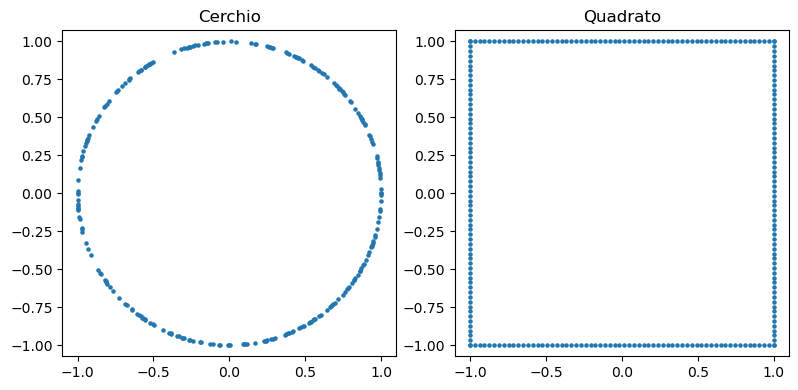

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
for a, data, title in zip(ax, [generate_circle_points(256), generate_square_points(256)], ["Cerchio", "Quadrato"]):
    a.scatter(data[:, 0], data[:, 1], s=5)
    a.set_title(title)
    a.axis('equal')
plt.tight_layout()
plt.show()



In [9]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))

    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))

    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)

        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t= x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

# Training

In [38]:
flow = Flow(dim=2)

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(100000):
    # a random flag to choose between circle and square
    figure = 1  # np.random.randint(0, 2)
    if figure == 0:
        x_1_base = generate_circle_points(256)
    else:
        x_1_base = generate_square_points(256)

    flag = torch.full((256, 1), float(figure))

    # add a padding to x_1 of 1 dimension
    x_1 = x_1_base  # torch.concat([x_1_base, flag], dim=1)
    x_0 = generate_circle_points(256) # torch.concat([torch.randn_like(x_1_base), flag], dim=1)

    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

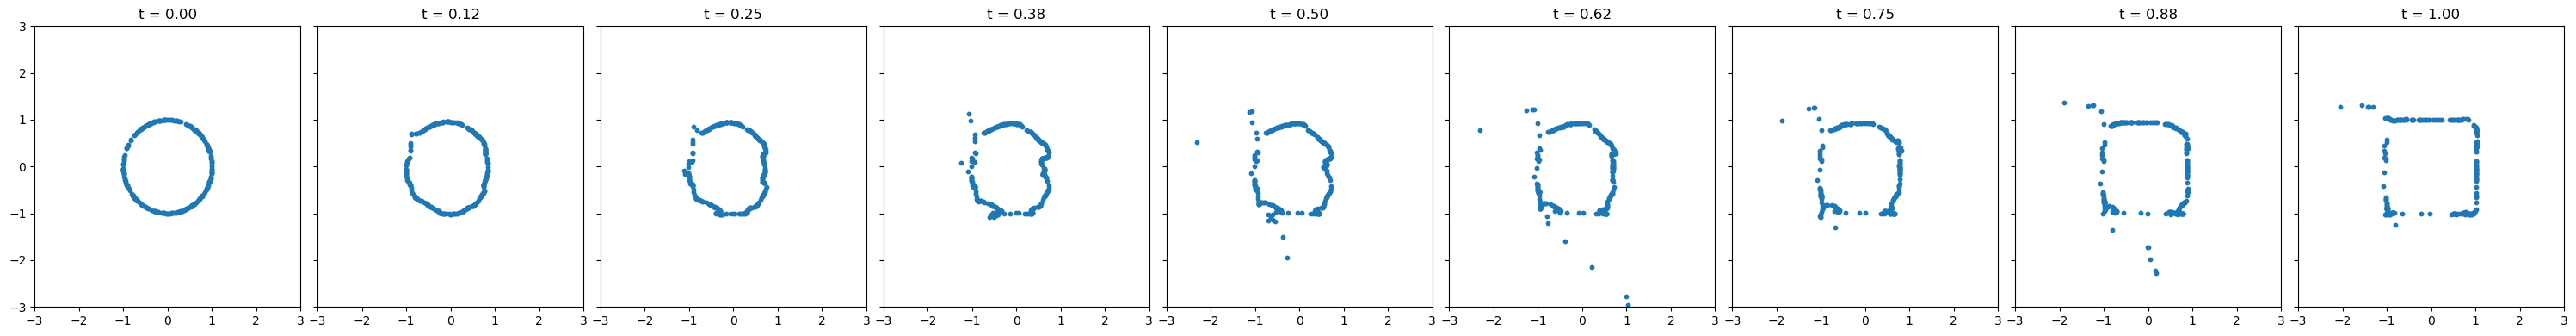

In [74]:
# Inizializza un rumore (x_0) con 2 dimensioni
x = generate_circle_points(256)

n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()


In [78]:
flow = Flow(dim=2)

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(100000):
    # a random flag to choose between circle and square
    figure = np.random.randint(0, 2)
    if figure == 0:
        x_1 = generate_circle_points(256)
        x_0 = generate_square_points(256)
    else:
        x_1 = generate_square_points(256)
        x_0 = generate_circle_points(256)

    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

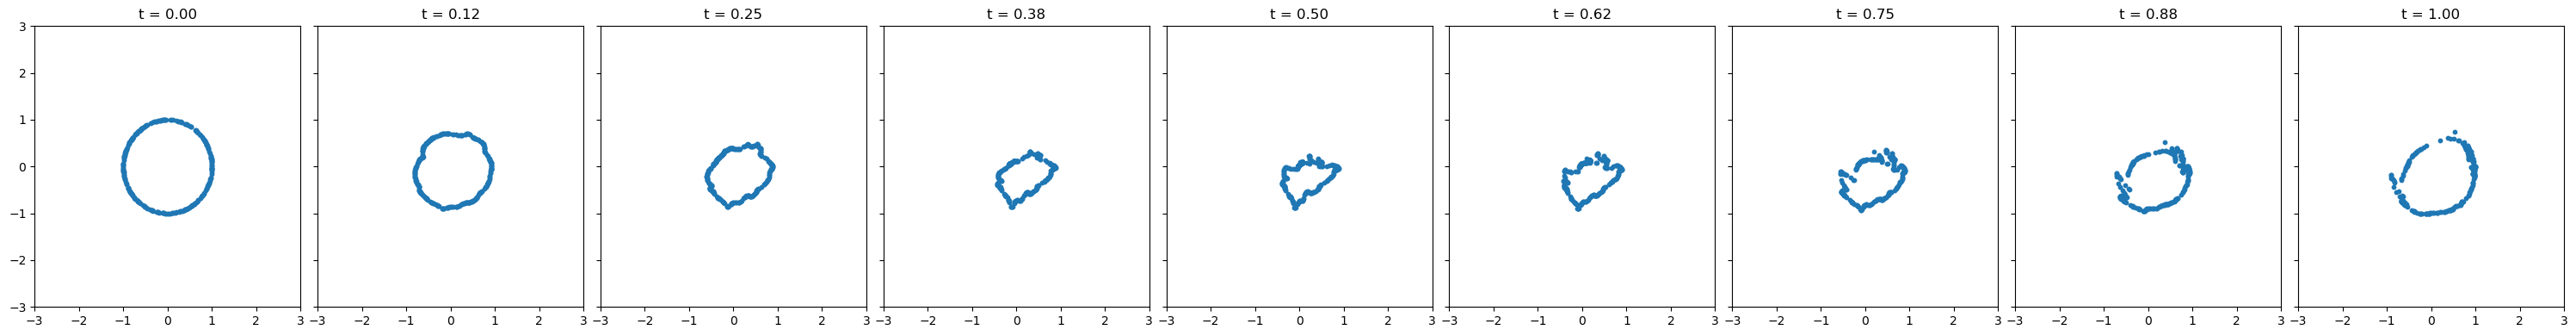

In [86]:
# Inizializza un rumore (x_0) con 2 dimensioni
flag = 1
if flag == 0:
    x = generate_square_points(256)
else:
    x = generate_circle_points(256)

n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()


In [99]:
flow = Flow(dim=3)

optimizer = torch.optim.Adam(flow.parameters(), 1e-2)
loss_fn = nn.MSELoss()

for _ in range(300000):
    # a random flag to choose between circle and square
    figure = np.random.randint(0, 2)
    if figure == 0:
        x_1_base = generate_circle_points(256)
        x_0_base = generate_square_points(256)
    else:
        x_1_base = generate_square_points(256)
        x_0_base = generate_circle_points(256)

    flag = torch.full((256, 1), float(figure))

    # add a padding to x_1 of 1 dimension
    x_1 = torch.concat([x_1_base, flag], dim=1)
    x_0 = torch.concat([x_0_base, flag], dim=1)

    t = torch.rand(len(x_1), 1)
    x_t = (1 - t) * x_0 + t * x_1
    dx_t = x_1 - x_0

    optimizer.zero_grad()
    loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    optimizer.step()

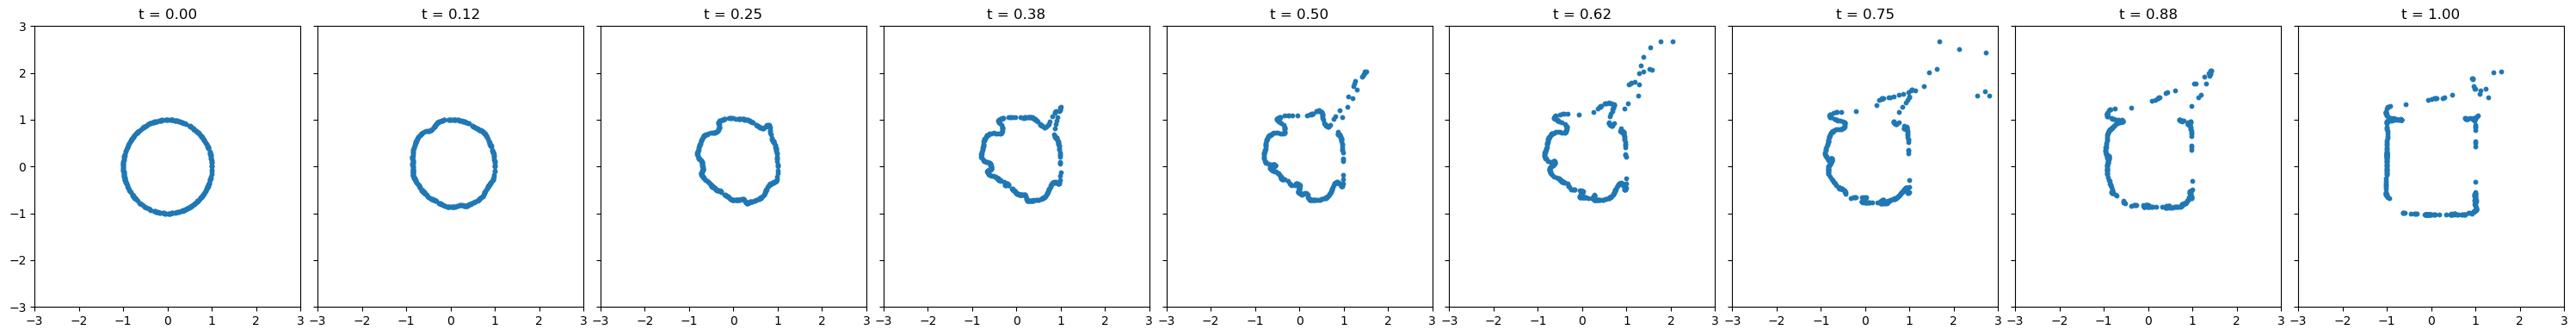

In [105]:
# scegli la figura da generare (0 = cerchio, 1 = quadrato)
figure = 1  # oppure 1
flag = torch.full((300, 1), float(figure))  # flag costante per tutto il batch

# rumore + flag
if figure == 0:
    x = generate_square_points(300)
else:
    x = generate_circle_points(300)
x = torch.cat([x, flag], dim=1)

n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()

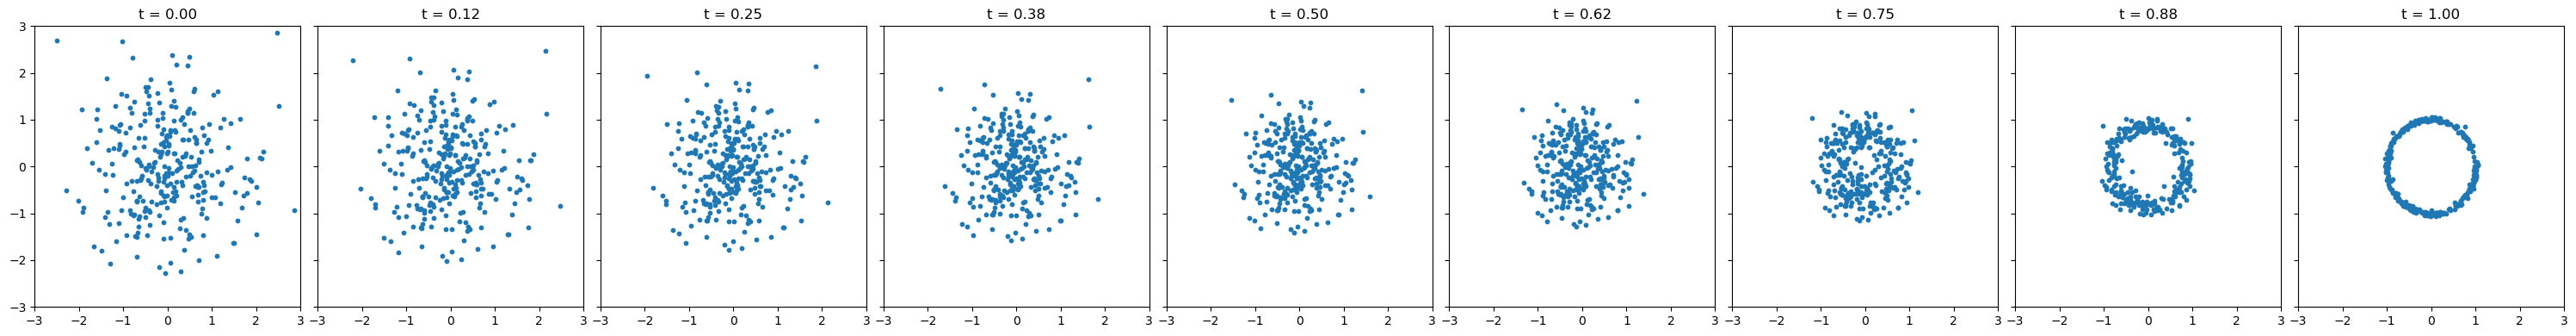

In [33]:
# scegli la figura da generare (0 = cerchio, 1 = quadrato)
figure = 0  # oppure 1
flag = torch.full((300, 1), float(figure))  # flag costante per tutto il batch

# rumore + flag
x = torch.randn(300, 2)
x = torch.cat([x, flag], dim=1)

n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

axes[0].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    axes[i + 1].scatter(x[:, 0].detach(), x[:, 1].detach(), s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()


In [45]:
import torch
import matplotlib.pyplot as plt
import imageio
import os

# Crea una cartella temporanea per i frame
os.makedirs("frames", exist_ok=True)

x = torch.randn(300, 2)
n_steps = 8
time_steps = torch.linspace(0, 1.0, n_steps + 1)

filenames = []

for i in range(n_steps + 1):
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.set_xlim(-3.0, 3.0)
    ax.set_ylim(-3.0, 3.0)
    ax.set_title(f't = {time_steps[i]:.2f}')
    ax.scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)

    filename = f"frames/frame_{i:02d}.png"
    filenames.append(filename)
    plt.savefig(filename)
    plt.close()

    if i < n_steps:
        x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])

# Crea la GIF
gif_filename = "cetriolo_flow.gif"
with imageio.get_writer(gif_filename, mode='I', duration=0.4) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print(f"GIF salvata come {gif_filename}")


GIF salvata come cetriolo_flow.gif


<ipython-input-45-78a9a7cdadc1>:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [51]:
from sklearn.datasets import make_moons
import torch
import numpy as np

def get_training_batch(n_samples=256):
    # x_1: dati target (moon)
    x_1 = torch.tensor(make_moons(n_samples, noise=0.05)[0], dtype=torch.float32)  # shape (256, 2)

    # cetriolo: shape (256, 2)
    cucumber = generate_target_points(n_samples)

    # rumore: shape (256, 2)
    noise = torch.randn(n_samples, 2)

    # x_0: concatenazione rumore + cetriolo: shape (256, 4)
    x_0 = torch.cat([noise, cucumber], dim=1)

    return x_0, x_1


In [60]:
flow = Flow(dim=4)
for _ in range(50000):
    x_0, x_1 = get_training_batch(256)  # x_0: (256, 4), x_1: (256, 2)

    t = torch.rand(len(x_1), 1)

    # Interpolazione lineare tra 4D (x_0) e 2D (x_1) non ha senso: padding necessario
    # Allora, espandi x_1 a 4D per l'interpolazione, mettendo zeri (o rumore) nei canali extra
    x_1_expanded = torch.cat([x_1, torch.zeros_like(x_1)], dim=1)  # shape (256, 4)

    x_t = (1 - t) * x_0 + t * x_1_expanded  # shape (256, 4)
    dx_t = x_1_expanded - x_0  # target derivative

    optimizer.zero_grad()
    loss = loss_fn(flow(t=t, x_t=x_t), dx_t)
    loss.backward()
    optimizer.step()


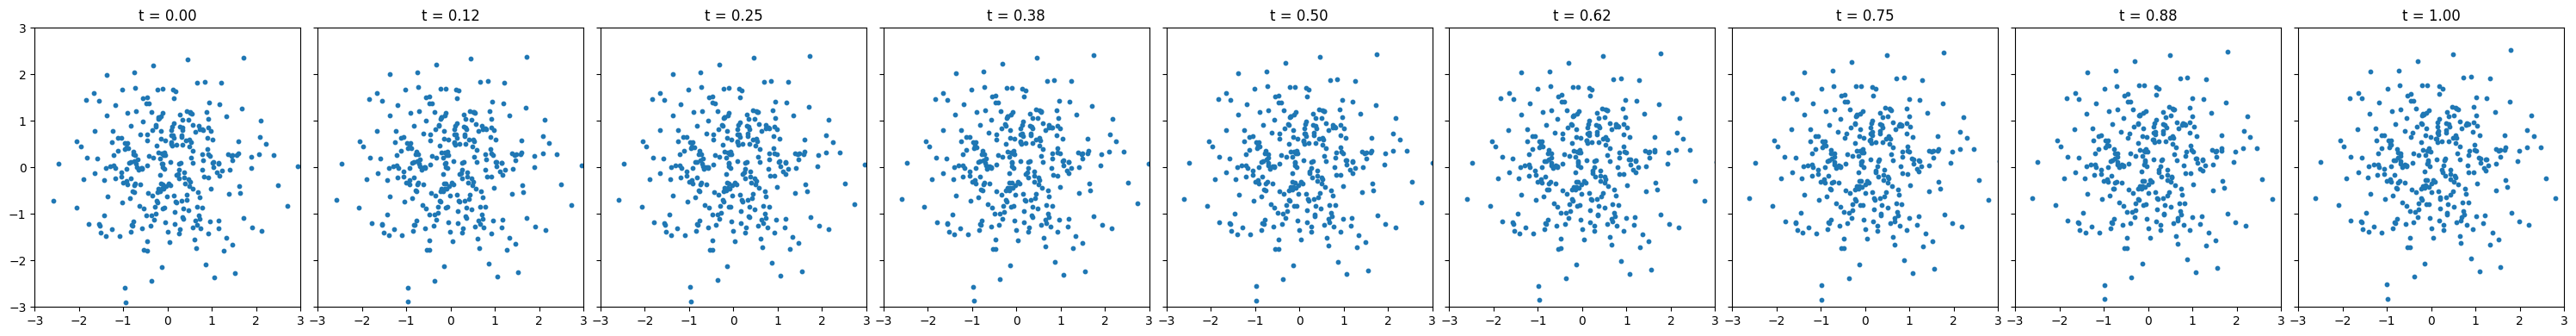

In [65]:
x = torch.randn(300, 2)  # rumore
cucumber = generate_target_points(300)  # cetriolo
x = torch.cat([x, cucumber], dim=1)  # x ha shape (300, 4)

n_steps = 8
fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
time_steps = torch.linspace(0, 1.0, n_steps + 1)

# Visualizza solo la parte "cetriolo"
axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
axes[0].set_title(f't = {time_steps[0]:.2f}')
axes[0].set_xlim(-3.0, 3.0)
axes[0].set_ylim(-3.0, 3.0)

for i in range(n_steps):
    x = flow.step(x_t=x, t_start=time_steps[i], t_end=time_steps[i + 1])
    cucumber_part = x.detach()[:, :2]  # estrai la parte del cetriolo
    axes[i + 1].scatter(cucumber_part[:, 0], cucumber_part[:, 1], s=10)
    axes[i + 1].set_title(f't = {time_steps[i + 1]:.2f}')

plt.tight_layout()
plt.show()
